In [1]:
import sys
import os
import uproot
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats as st
import scipy

import peakutils

from datetime import datetime

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
### Import functions from peak_functions

repository_path = os.path.abspath('..')
sys.path.append(repository_path)

import peak_functions as pf
import fit_functions  as fitf
import blr_functions  as blr

In [4]:
plt.rcParams["figure.figsize"] = 9, 6
plt.rcParams["font.size"]      = 14

In [5]:
filename = '/Users/romoluque_c/LEGEND/BACON/datatest/run-06_02_2023-file.root'
infile   = uproot.open(filename)
RawTree  = infile['RawTree']

In [6]:
total_SiPMs = 9
dead_SiPMs  = [3]

RawTree    = infile['RawTree']
peak_range = (0,None)
num_wfs    = None # All wfs

sipm_thr = 50 #ADCs
peak_sep = 10

int_subt_wfs_filt = [np.array([]) for _ in range(total_SiPMs)]

for channel in range(total_SiPMs):
    print(channel)
    if channel in dead_SiPMs:
        continue
    try:
        _, subt_wfs_filt, all_peaks = pf.get_peaks_using_peakutils(RawTree, channel, num_wfs=num_wfs, sipm_thr=sipm_thr, peak_range=peak_range)
        int_subt_wf_filt = np.sum(subt_wfs_filt, axis=0)
    except ValueError:
        continue

    int_subt_wfs_filt[channel] = np.append(int_subt_wfs_filt[channel], int_subt_wf_filt)

int_subt_wfs_filt = np.array(int_subt_wfs_filt, dtype=object)

0
1
2
3
4
5
6
7
8


In [7]:
int_subt_wf_filt

array([10590.,  7220., 10605., ...,  7533.,  9152.,  8090.], dtype=float32)

In [8]:
int_subt_wfs_filt

array([array([2032., 4221., 3585., ..., 3443., 2090., 4283.]),
       array([2623., 3343., 4716., ..., 1589., 4018., 5285.]),
       array([1632., 1030., 3249., ..., 2158., 3745., 1746.]),
       array([], dtype=float64),
       array([ 2964., 16243.,   890., ..., 13765.,  -234.,  4832.]),
       array([5992., 5690., 6273., ..., 6412., 5745.,  403.]),
       array([1245., 1381., 1163., ...,  935.,  957., 1380.]),
       array([7340., 4634., 9505., ...,  997., 6532., 1520.]),
       array([10590.,  7220., 10605., ...,  7533.,  9152.,  8090.])],
      dtype=object)

In [9]:
len(int_subt_wfs_filt[0])

7500

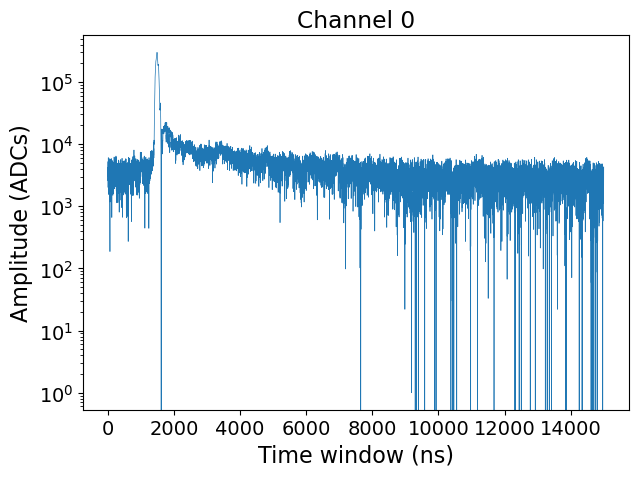

In [10]:
plt.figure(figsize=(7, 5))
channel  = 0
wf = int_subt_wfs_filt[0]
plt.plot(2*np.arange(len(wf)), wf, linewidth=0.5)
plt.xlabel('Time window (ns)', fontsize=16)
plt.ylabel('Amplitude (ADCs)', fontsize=16)
plt.title(f"Channel {channel}")
plt.tight_layout()
plt.yscale('log')
plt.show()

7500
7500
7500
7500
7500
7500
7500
7500


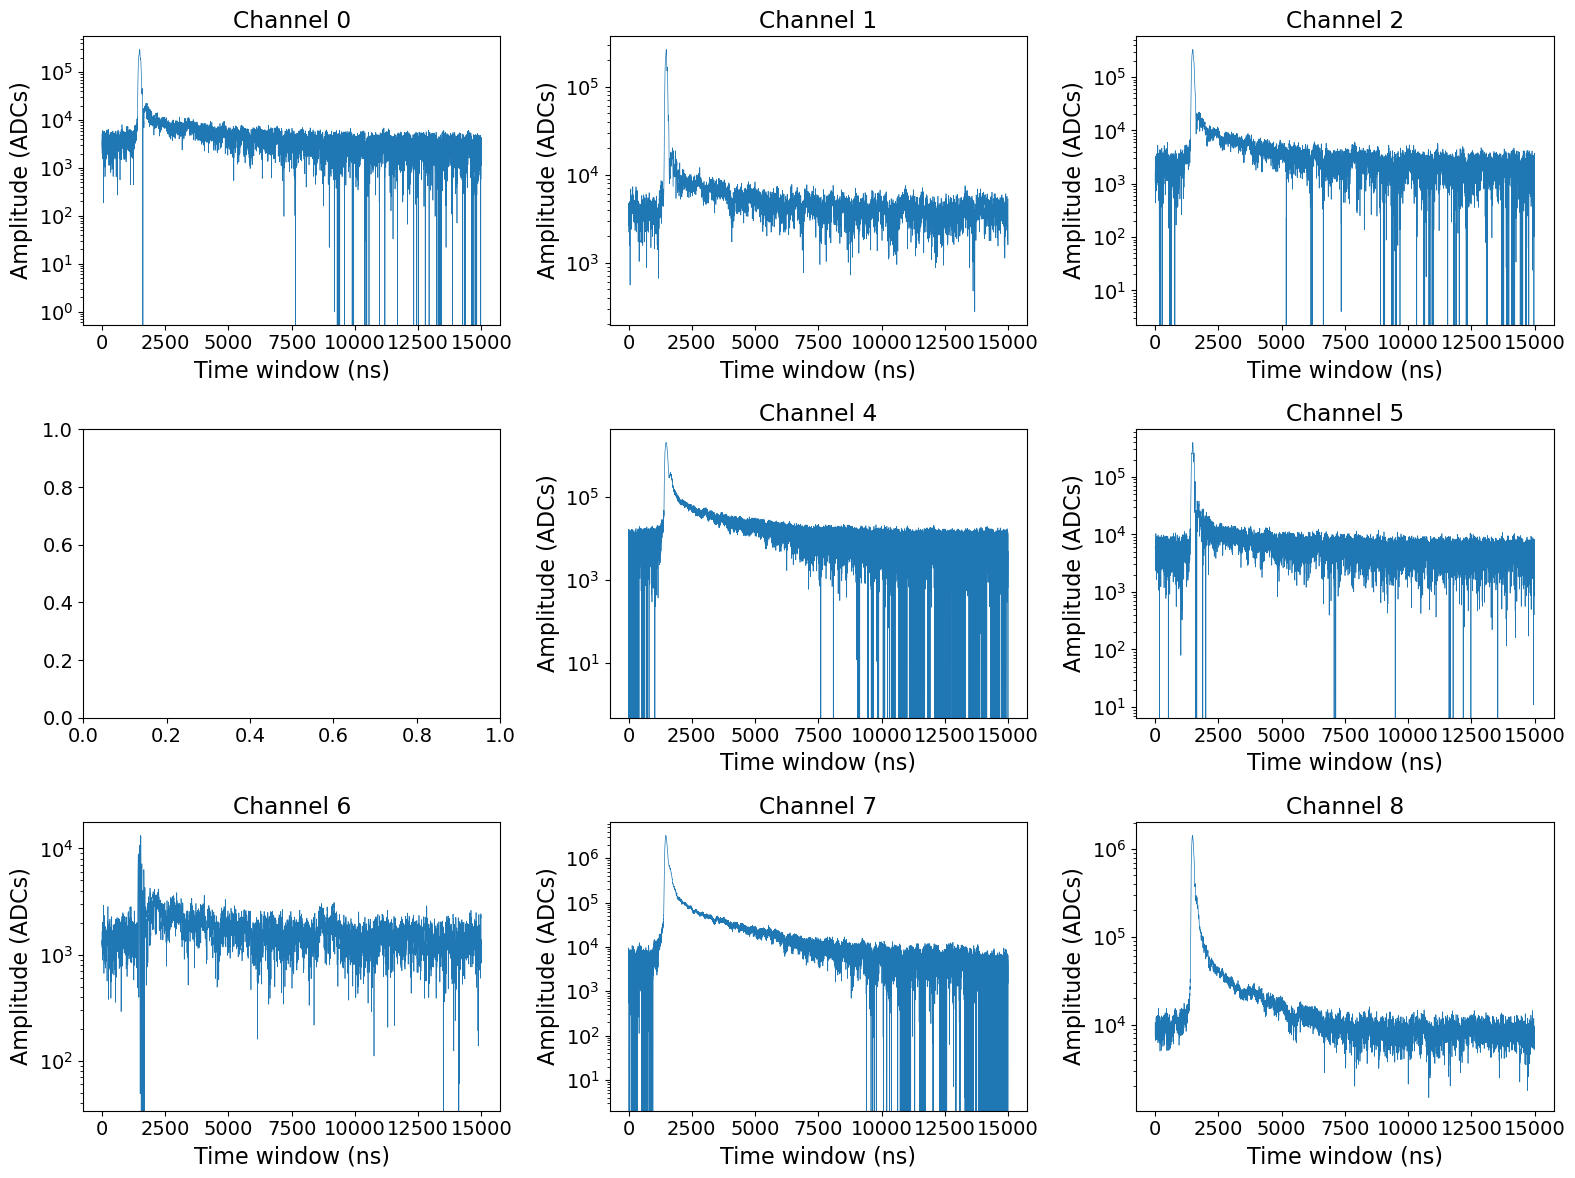

In [11]:
fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for k in range(9):
    if k==3: continue
    i = int(k/3)
    j = k%3
    wf = int_subt_wfs_filt[k]
    print(len(wf))
    axs[i][j].plot(2*np.arange(len(wf)), wf, linewidth=0.5)
    axs[i][j].set_xlabel('Time window (ns)', fontsize=16)
    axs[i][j].set_ylabel('Amplitude (ADCs)', fontsize=16)
    axs[i][j].set_title(f"Channel {k}")
    axs[i][j].set_yscale('log')
plt.tight_layout()
plt.show()

### Analysis npz data and prepare data:

In [12]:
evts_path = '/Users/romoluque_c/LEGEND/BACON/data_npz/'

all_channels = 9

int_subt_wfs_filt_dict = {}

pos_date1 = 37
pos_date2 = 47

def get_date(filename):
    date_str = filename[pos_date1:pos_date2]
    date = datetime.strptime(date_str, '%m_%d_%Y')
    return date

files        = os.listdir(evts_path)
filt_files   = [file for file in files if file.startswith("BACoN_sig_processing_light")]
sorted_files = sorted(filt_files, key=get_date)

for filename in sorted_files:
    my_file = evts_path+filename
    d = np.load(my_file, allow_pickle=True)
    
    date = filename[pos_date1:pos_date2]
    
    if date not in int_subt_wfs_filt_dict:
        int_subt_wfs_filt  = [np.array([]) for _ in range(all_channels)]

    for channel in range(all_channels):
        if channel==3:
            continue
        int_subt_wfs_filt[channel] = np.append(int_subt_wfs_filt[channel], d['int_subt_wfs_filt'] [channel])
        
    int_subt_wfs_filt_dict[date] = np.array(int_subt_wfs_filt, dtype=object)

In [13]:
int_subt_wfs_filt_dict;

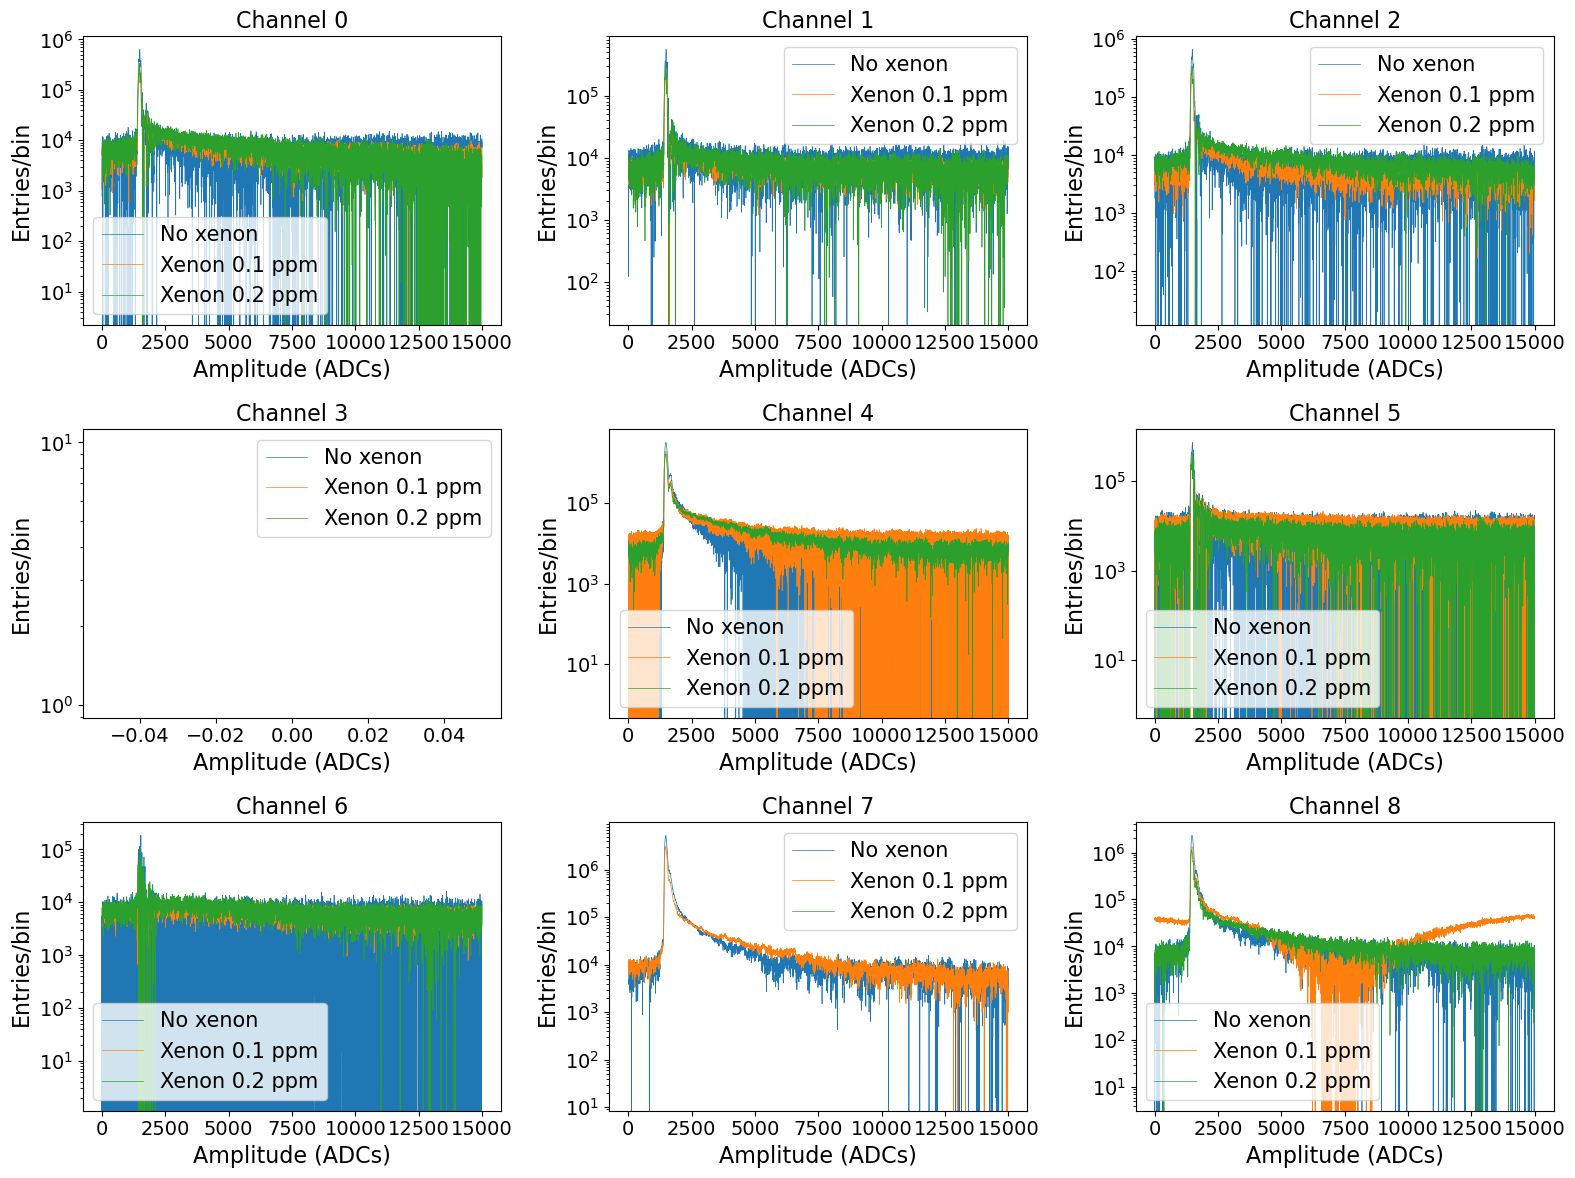

In [14]:
select_date1 = '05_30_2023'
select_date2 = '06_20_2023'
select_date3 = '07_06_2023'

fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for k in range(9):
    i = int(k/3)
    j = k%3
    wf1 = int_subt_wfs_filt_dict[select_date1][k][:7500]
    wf2 = int_subt_wfs_filt_dict[select_date2][k][:7500]
    wf3 = int_subt_wfs_filt_dict[select_date3][k][:7500]
    axs[i][j].plot(2*np.arange(len(wf1)), wf1, linewidth=0.5, label=f'No xenon')
    axs[i][j].plot(2*np.arange(len(wf2)), wf2, linewidth=0.5, label=f'Xenon 0.1 ppm')
    axs[i][j].plot(2*np.arange(len(wf3)), wf3, linewidth=0.5, label=f'Xenon 0.2 ppm')
    axs[i][j].set_xlabel('Amplitude (ADCs)', fontsize=16)
    axs[i][j].set_ylabel('Entries/bin',      fontsize=16)
    axs[i][j].set_title(f"Channel {k}",      fontsize=16)
    axs[i][j].legend(fontsize=15)
    axs[i][j].set_yscale('log')
plt.tight_layout()
plt.show()

In [15]:
len(int_subt_wfs_filt_dict['05_30_2023'][0])/7500

108.0

In [16]:
def sum_wfs_files(data, chunk_size=7500):
    num_chunks = len(data) // chunk_size
    sum_chunks = np.array([])
    for i in range(num_chunks):
        if i == 0:
            sum_chunks = data[:chunk_size]
        else:
            start = i * chunk_size
            end   = (i + 1) * chunk_size
            chunk = data[start:end]
            sum_chunks = np.add(sum_chunks, chunk)
    return sum_chunks

In [17]:
sum_test = sum_wfs_files(int_subt_wfs_filt_dict['05_30_2023'][0], chunk_size=7500)

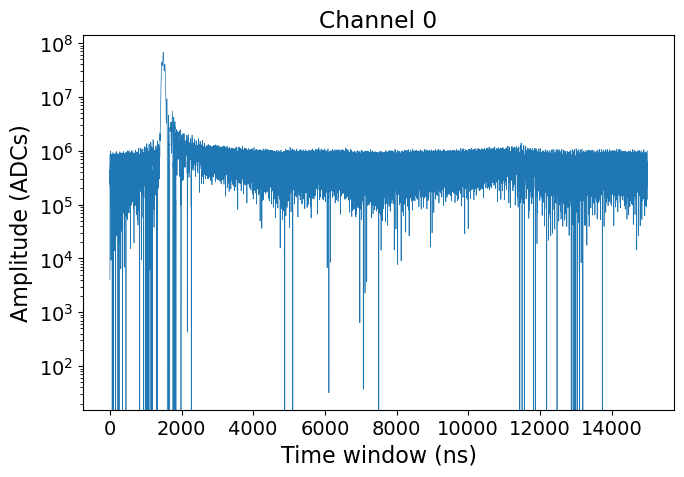

In [18]:
plt.figure(figsize=(7, 5))
channel  = 0
wf0 = sum_test
plt.plot(2*np.arange(len(wf0)), wf0, linewidth=0.5)
plt.xlabel('Time window (ns)', fontsize=16)
plt.ylabel('Amplitude (ADCs)', fontsize=16)
plt.title(f"Channel {channel}")
plt.tight_layout()
plt.yscale('log')
plt.show()

In [19]:
sum_wfs_dict = {}
for key, vals in int_subt_wfs_filt_dict.items():
    sum_wfs_dict[key] = np.array([sum_wfs_files(val) for val in vals])

In [20]:
sum_wfs_dict;

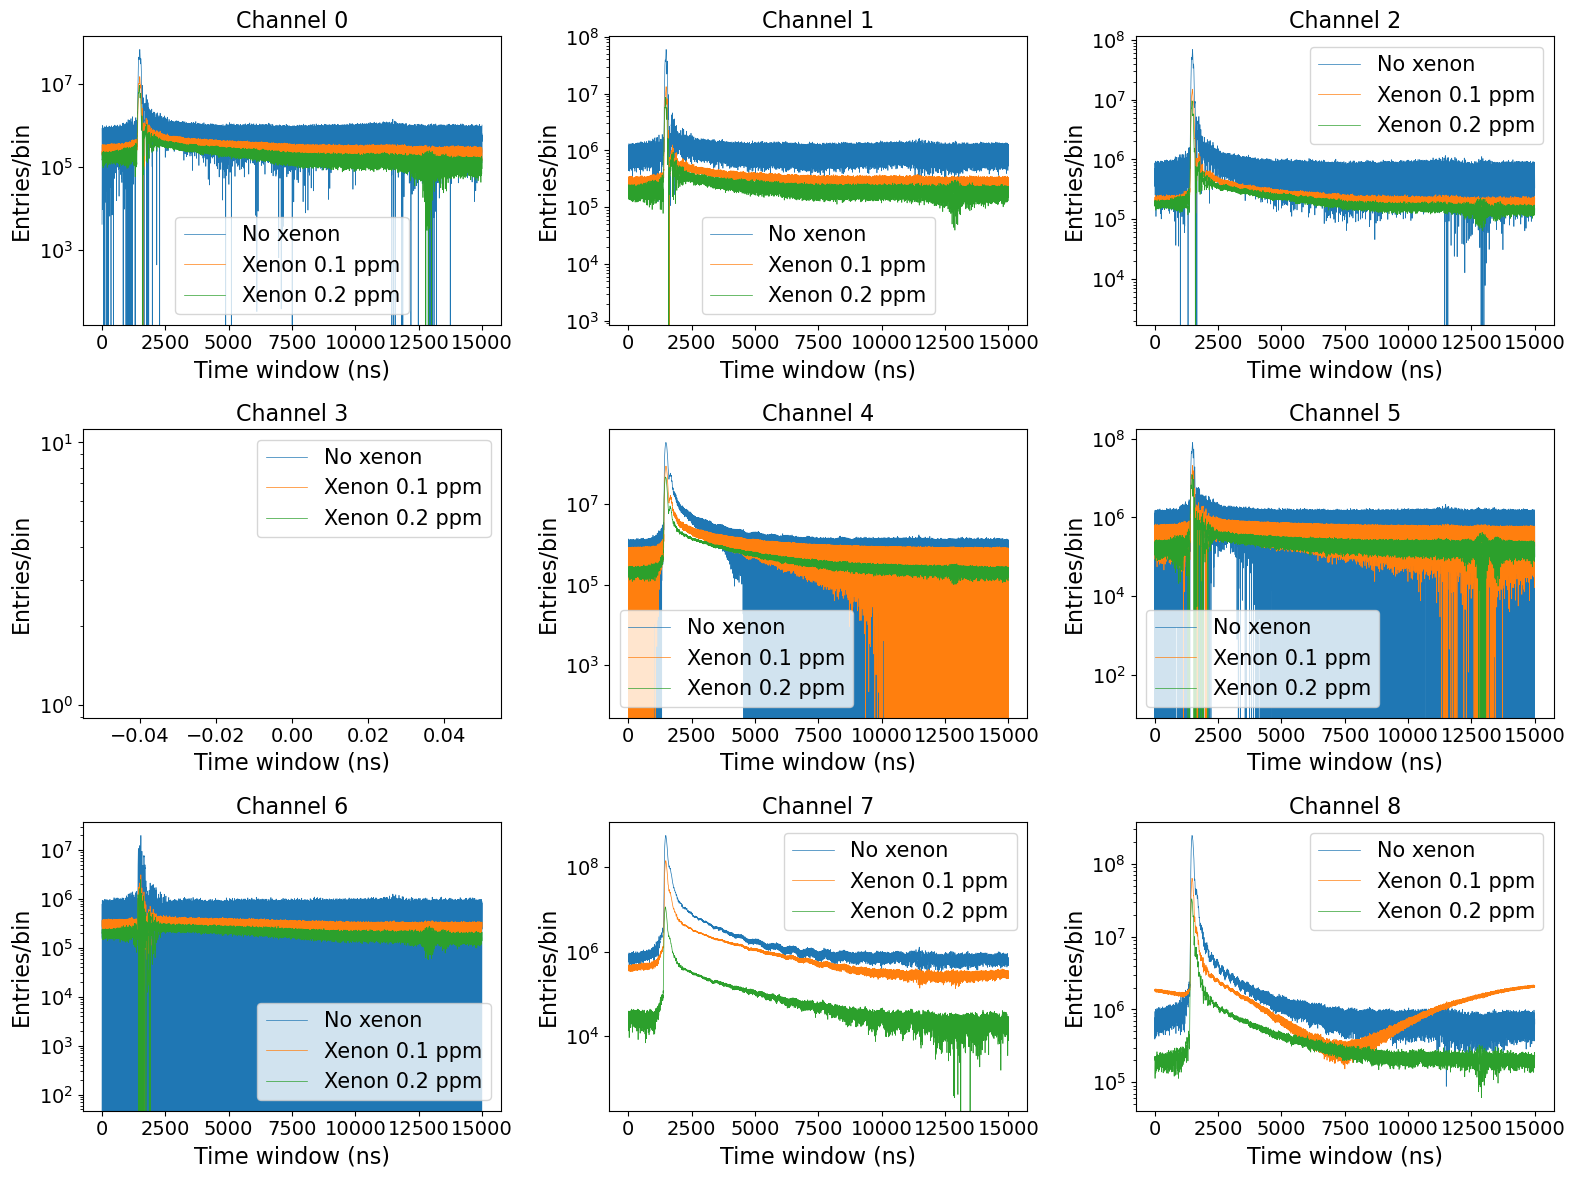

In [21]:
select_date1 = '05_30_2023'
select_date2 = '06_20_2023'
select_date3 = '07_06_2023'

fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for k in range(9):
    i = int(k/3)
    j = k%3
    wf1 = sum_wfs_dict[select_date1][k]
    wf2 = sum_wfs_dict[select_date2][k]
    wf3 = sum_wfs_dict[select_date3][k]
    axs[i][j].plot(2*np.arange(len(wf1)), wf1, linewidth=0.5, label=f'No xenon')
    axs[i][j].plot(2*np.arange(len(wf2)), wf2, linewidth=0.5, label=f'Xenon 0.1 ppm')
    axs[i][j].plot(2*np.arange(len(wf3)), wf3, linewidth=0.5, label=f'Xenon 0.2 ppm')
    axs[i][j].set_xlabel('Time window (ns)', fontsize=16)
    axs[i][j].set_ylabel('Entries/bin',      fontsize=16)
    axs[i][j].set_title(f"Channel {k}",      fontsize=16)
    axs[i][j].legend(fontsize=15)
    axs[i][j].set_yscale('log')
plt.tight_layout()
plt.show()

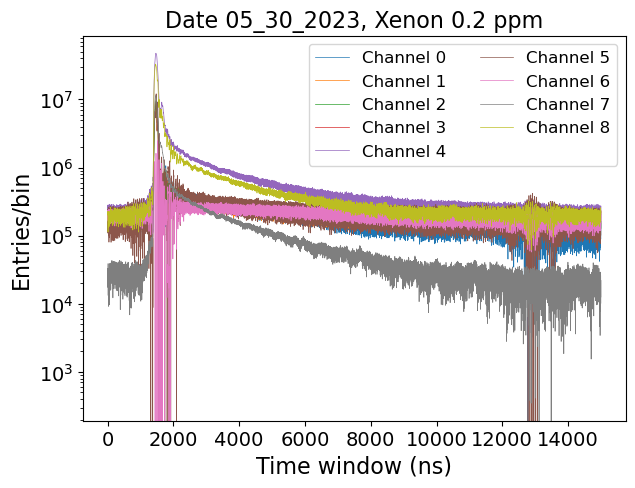

In [22]:
select_date = '07_06_2023'

plt.figure(figsize=(7, 5))
for k in range(9):
    i = int(k/3)
    j = k%3
    wf = sum_wfs_dict[select_date][k]
    plt.plot(2*np.arange(len(wf)), wf, linewidth=0.5, label=f'Channel {k}')
    plt.xlabel('Time window (ns)', fontsize=16)
    plt.ylabel('Entries/bin',      fontsize=16)
plt.title(f"Date {select_date1}, Xenon 0.2 ppm", fontsize=16)
plt.legend(fontsize=12, ncol=2)
plt.yscale('log')
plt.show()

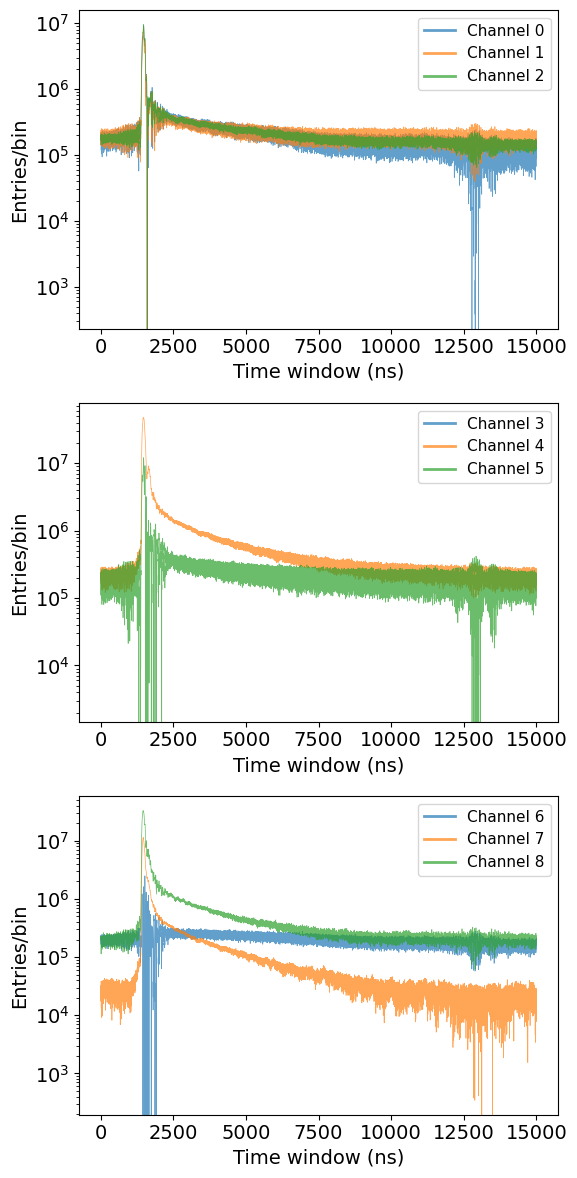

In [23]:
select_date = '07_06_2023'
fig, axs = plt.subplots(3, 1, figsize=(6, 12))
for k in range(9):
    i  = int(k/3)
    wf = sum_wfs_dict[select_date][k]
    axs[i].plot(2*np.arange(len(wf)), wf, linewidth=0.5, label=f'Channel {k}', alpha=0.7)
    axs[i].set_xlabel('Time window (ns)', fontsize=14)
    axs[i].set_ylabel('Entries/bin',      fontsize=14)
    axs[i].set_yscale('log')
    leg = axs[i].legend(fontsize=11)
    for line in leg.get_lines():
        line.set_linewidth(2)

plt.tight_layout()
plt.show()

## No xenon:


                      ---------------------------------------
                      -------------- No XENON ---------------
                      ---------------------------------------



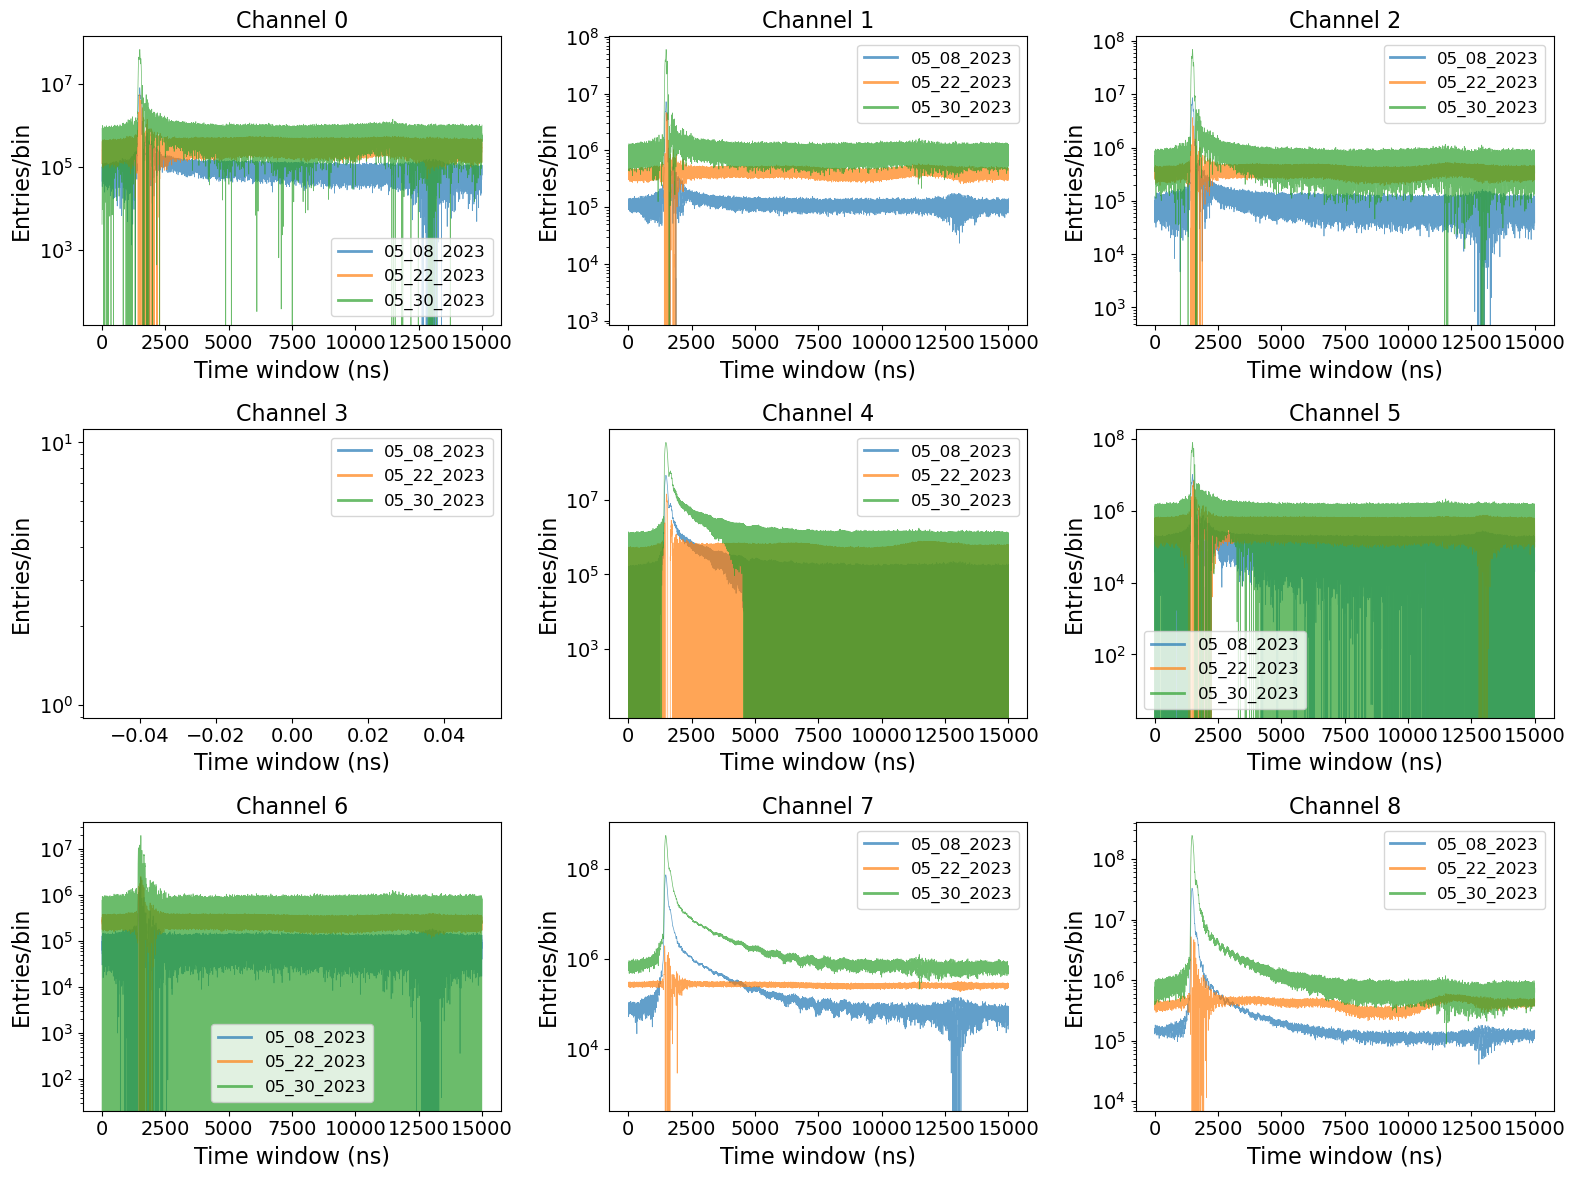

In [24]:
print('')
print('                      ---------------------------------------')
print('                      -------------- No XENON ---------------')
print('                      ---------------------------------------')
print('')

select_date1 = '05_08_2023'
select_date2 = '05_22_2023'
select_date3 = '05_30_2023'

fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for k in range(9):
    i = int(k/3)
    j = k%3
    wf1 = sum_wfs_dict[select_date1][k]
    wf2 = sum_wfs_dict[select_date2][k]
    wf3 = sum_wfs_dict[select_date3][k]
    axs[i][j].plot(2*np.arange(len(wf1)), wf1, linewidth=0.5, label=f'{select_date1}', alpha=0.7)
    axs[i][j].plot(2*np.arange(len(wf2)), wf2, linewidth=0.5, label=f'{select_date2}', alpha=0.7)
    axs[i][j].plot(2*np.arange(len(wf3)), wf3, linewidth=0.5, label=f'{select_date3}', alpha=0.7)
    axs[i][j].set_xlabel('Time window (ns)', fontsize=16)
    axs[i][j].set_ylabel('Entries/bin',      fontsize=16)
    axs[i][j].set_title(f"Channel {k}",      fontsize=16)
    axs[i][j].set_yscale('log')
    leg = axs[i][j].legend(fontsize=12)
    for line in leg.get_lines():
        line.set_linewidth(2)
plt.tight_layout()
plt.show()


                      ---------------------------------------
                      ----------- 0.1 ppm XENON -------------
                      ---------------------------------------



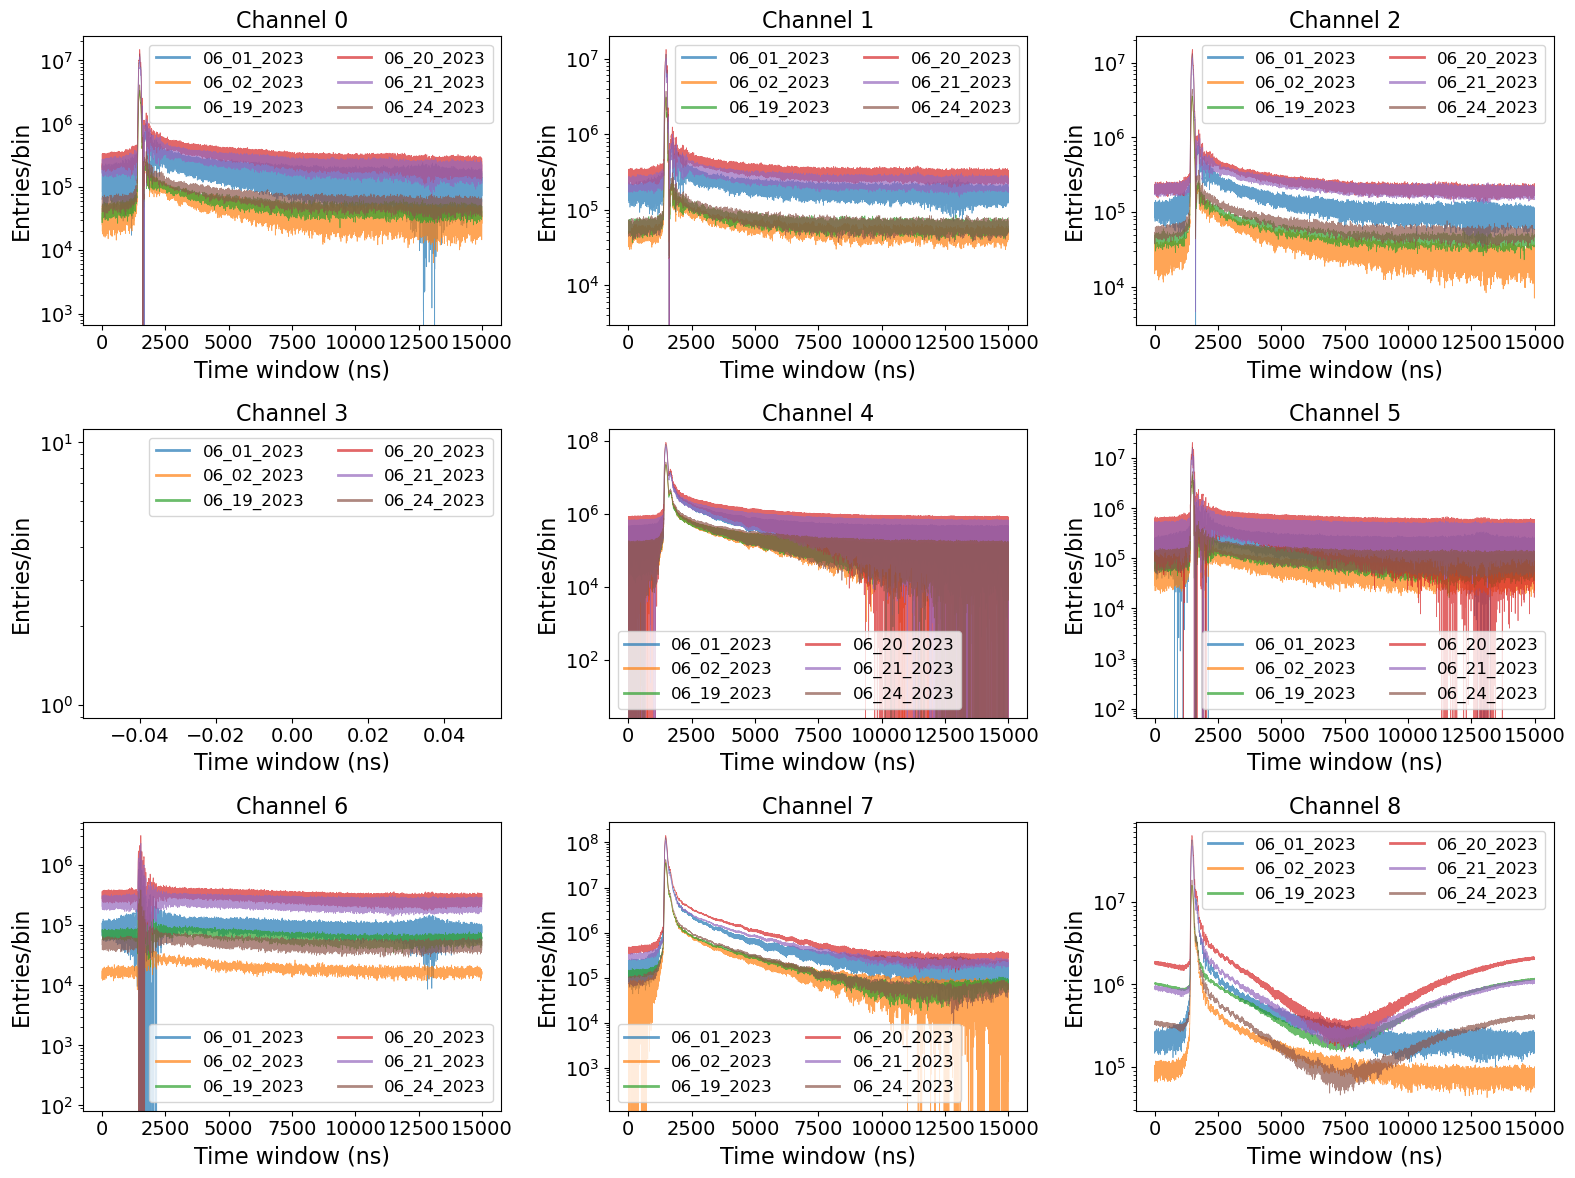

In [25]:
print('')
print('                      ---------------------------------------')
print('                      ----------- 0.1 ppm XENON -------------')
print('                      ---------------------------------------')
print('')

select_date1 = '06_01_2023'
select_date2 = '06_02_2023'
select_date3 = '06_19_2023'
select_date4 = '06_20_2023'
select_date5 = '06_21_2023'
select_date6 = '06_24_2023'

fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for k in range(9):
    i = int(k/3)
    j = k%3
    wf1 = sum_wfs_dict[select_date1][k]
    wf2 = sum_wfs_dict[select_date2][k]
    wf3 = sum_wfs_dict[select_date3][k]
    wf4 = sum_wfs_dict[select_date4][k]
    wf5 = sum_wfs_dict[select_date5][k]
    wf6 = sum_wfs_dict[select_date6][k]
    axs[i][j].plot(2*np.arange(len(wf1)), wf1, linewidth=0.5, label=f'{select_date1}', alpha=0.7)
    axs[i][j].plot(2*np.arange(len(wf2)), wf2, linewidth=0.5, label=f'{select_date2}', alpha=0.7)
    axs[i][j].plot(2*np.arange(len(wf3)), wf3, linewidth=0.5, label=f'{select_date3}', alpha=0.7)
    axs[i][j].plot(2*np.arange(len(wf4)), wf4, linewidth=0.5, label=f'{select_date4}', alpha=0.7)
    axs[i][j].plot(2*np.arange(len(wf5)), wf5, linewidth=0.5, label=f'{select_date5}', alpha=0.7)
    axs[i][j].plot(2*np.arange(len(wf6)), wf6, linewidth=0.5, label=f'{select_date6}', alpha=0.7)
    axs[i][j].set_xlabel('Time window (ns)', fontsize=16)
    axs[i][j].set_ylabel('Entries/bin',      fontsize=16)
    axs[i][j].set_title(f"Channel {k}",      fontsize=16)
    axs[i][j].set_yscale('log')
    leg = axs[i][j].legend(fontsize=12, ncol=2)
    for line in leg.get_lines():
        line.set_linewidth(2)
plt.tight_layout()
plt.show()


                      ---------------------------------------
                      ----------- 0.2 ppm XENON -------------
                      ---------------------------------------



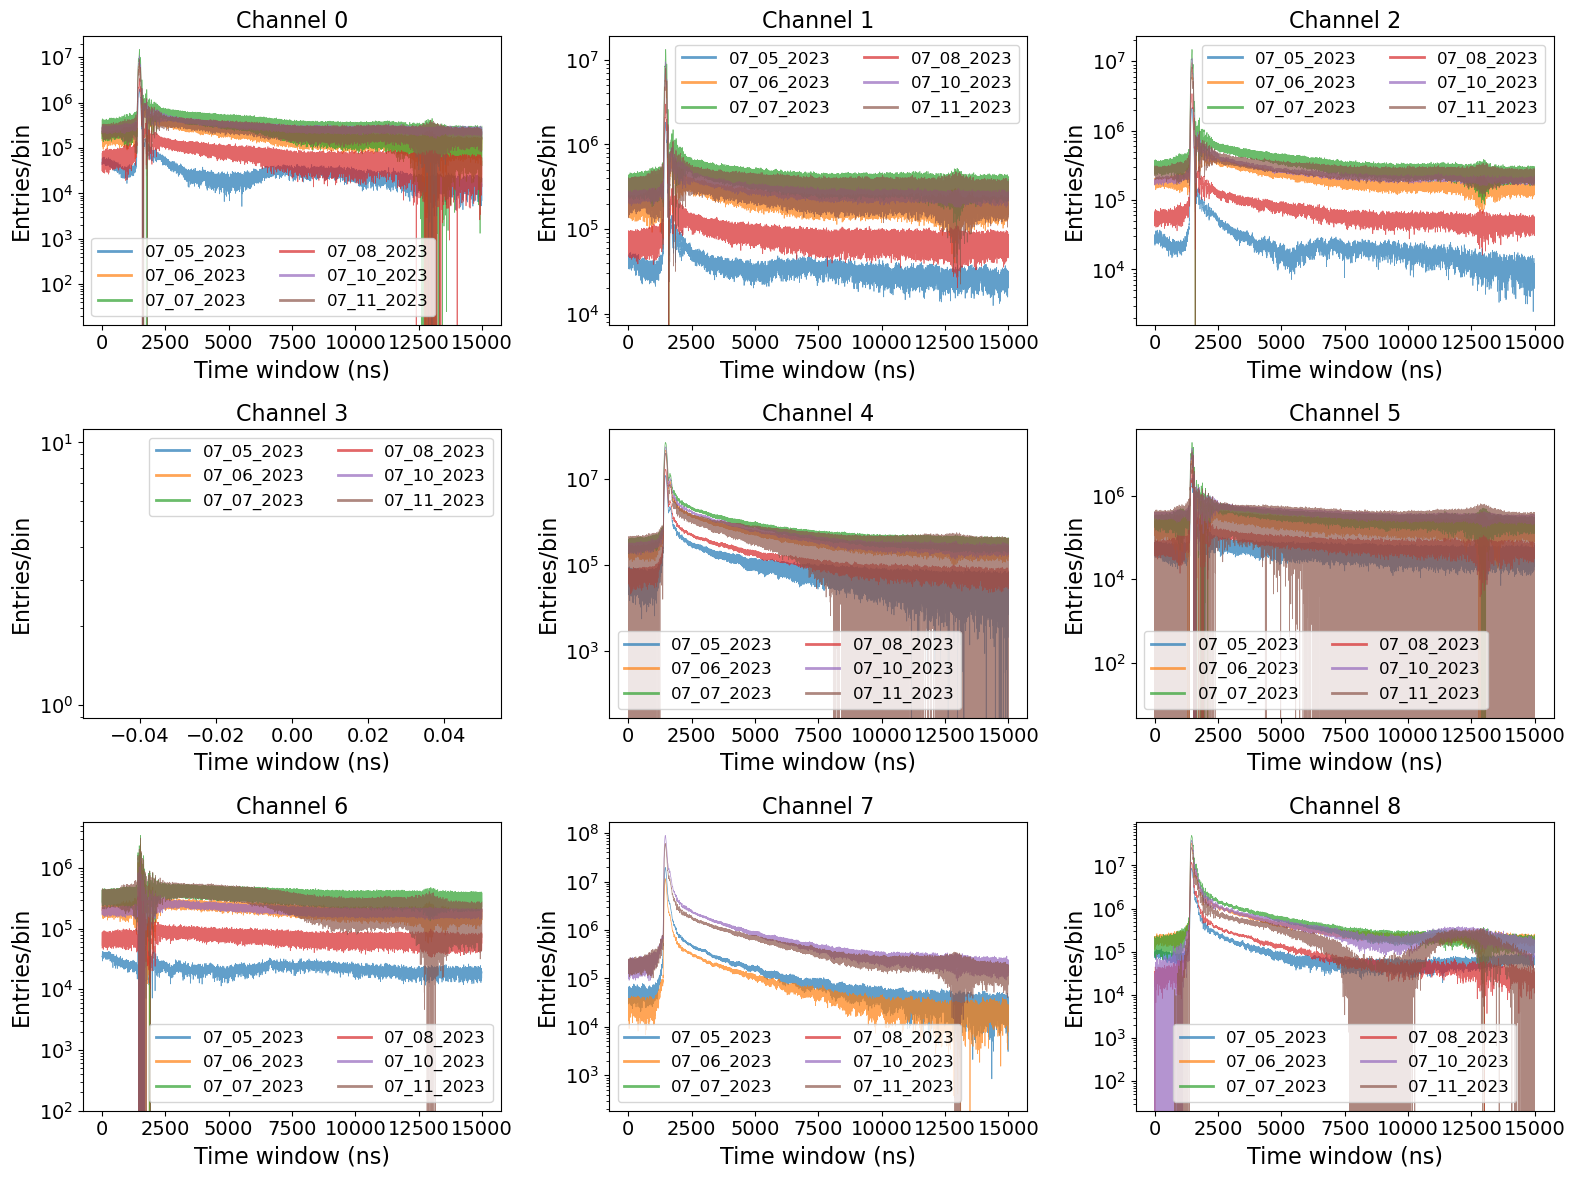

In [26]:
print('')
print('                      ---------------------------------------')
print('                      ----------- 0.2 ppm XENON -------------')
print('                      ---------------------------------------')
print('')

select_date1 = '07_05_2023'
select_date2 = '07_06_2023'
select_date3 = '07_07_2023'
select_date4 = '07_08_2023'
select_date5 = '07_10_2023'
select_date6 = '07_11_2023'

fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for k in range(9):
    i = int(k/3)
    j = k%3
    wf1 = sum_wfs_dict[select_date1][k]
    wf2 = sum_wfs_dict[select_date2][k]
    wf3 = sum_wfs_dict[select_date3][k]
    wf4 = sum_wfs_dict[select_date4][k]
    wf5 = sum_wfs_dict[select_date5][k]
    wf6 = sum_wfs_dict[select_date6][k]
    axs[i][j].plot(2*np.arange(len(wf1)), wf1, linewidth=0.5, label=f'{select_date1}', alpha=0.7)
    axs[i][j].plot(2*np.arange(len(wf2)), wf2, linewidth=0.5, label=f'{select_date2}', alpha=0.7)
    axs[i][j].plot(2*np.arange(len(wf3)), wf3, linewidth=0.5, label=f'{select_date3}', alpha=0.7)
    axs[i][j].plot(2*np.arange(len(wf4)), wf4, linewidth=0.5, label=f'{select_date4}', alpha=0.7)
    axs[i][j].plot(2*np.arange(len(wf5)), wf5, linewidth=0.5, label=f'{select_date5}', alpha=0.7)
    axs[i][j].plot(2*np.arange(len(wf6)), wf6, linewidth=0.5, label=f'{select_date6}', alpha=0.7)
    axs[i][j].set_xlabel('Time window (ns)', fontsize=16)
    axs[i][j].set_ylabel('Entries/bin',      fontsize=16)
    axs[i][j].set_title(f"Channel {k}",      fontsize=16)
    axs[i][j].set_yscale('log')
    leg = axs[i][j].legend(fontsize=12, ncol=2)
    for line in leg.get_lines():
        line.set_linewidth(2)
plt.tight_layout()
plt.show()


                      ---------------------------------------
                      ----------- 0.3 ppm XENON -------------
                      ---------------------------------------



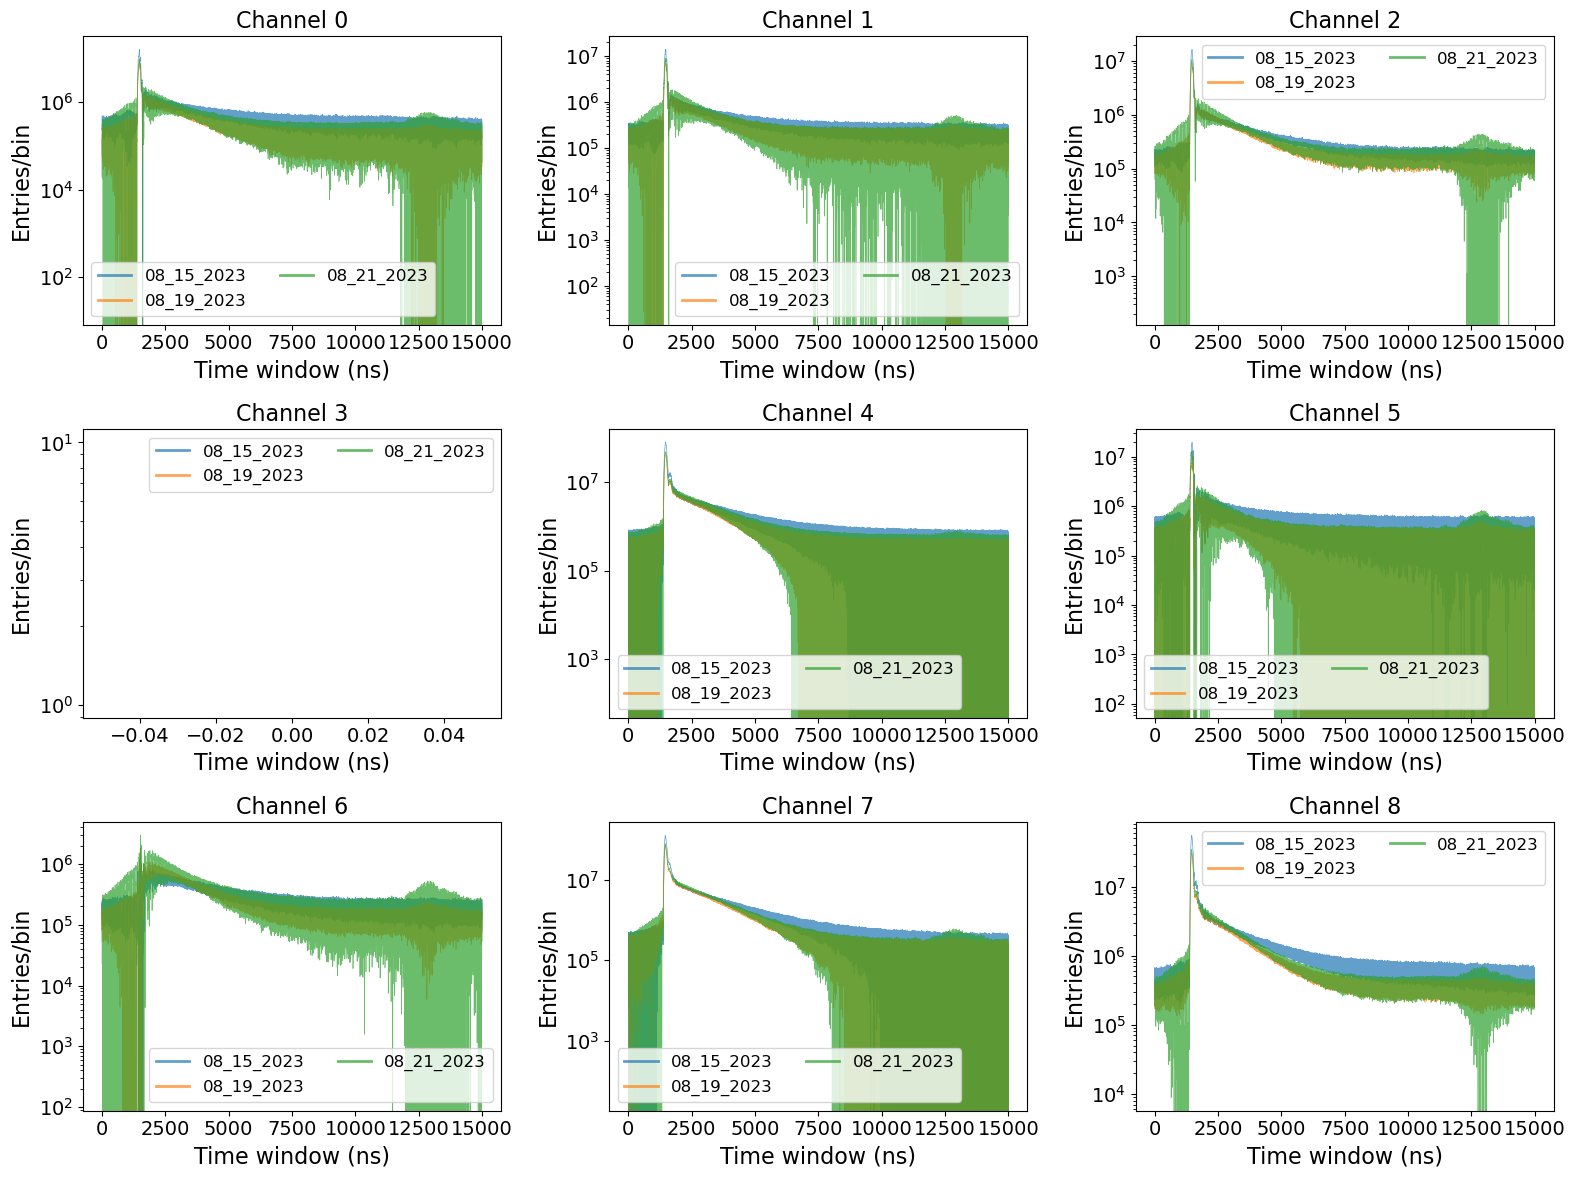

In [27]:
print('')
print('                      ---------------------------------------')
print('                      ----------- 0.3 ppm XENON -------------')
print('                      ---------------------------------------')
print('')

select_date1 = '08_1_2023'
select_date2 = '08_19_2023'
select_date3 = '08_21_2023'
select_date1 = '08_15_2023'
select_date2 = '08_19_2023'
select_date3 = '08_21_2023'

fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for k in range(9):
    i = int(k/3)
    j = k%3
    wf1 = sum_wfs_dict[select_date1][k]
    wf2 = sum_wfs_dict[select_date2][k]
    wf3 = sum_wfs_dict[select_date3][k]
    axs[i][j].plot(2*np.arange(len(wf1)), wf1, linewidth=0.5, label=f'{select_date1}', alpha=0.7)
    axs[i][j].plot(2*np.arange(len(wf2)), wf2, linewidth=0.5, label=f'{select_date2}', alpha=0.7)
    axs[i][j].plot(2*np.arange(len(wf3)), wf3, linewidth=0.5, label=f'{select_date3}', alpha=0.7)
    axs[i][j].set_xlabel('Time window (ns)', fontsize=16)
    axs[i][j].set_ylabel('Entries/bin',      fontsize=16)
    axs[i][j].set_title(f"Channel {k}",      fontsize=16)
    axs[i][j].set_yscale('log')
    leg = axs[i][j].legend(fontsize=12, ncol=2)
    for line in leg.get_lines():
        line.set_linewidth(2)
plt.tight_layout()
plt.show()

## Normalize the sum of wfs with the channel gains and the number of triggers

In [28]:
num_triggers = {}
for key, vals in int_subt_wfs_filt_dict.items():
    sum_wfs_dict[key] = np.array([sum_wfs_files(val) for val in vals])

In [29]:
mean_gains = [129.415, 122.037, 129.645, 0.0, 226.797, 112.980, 211.381, 213.928, 220.099]

In [30]:
range(9)[6]

6

In [31]:
list(range(8))

[0, 1, 2, 3, 4, 5, 6, 7]

In [33]:
##test

my_arr = np.array([np.array([2, 3, 4]), np.array([2, 3, 4]), np.array([2, 0, 4]), np.array([2, 0, 4])])
np.sum(my_arr, axis=0), np.sum(my_arr, axis=1)

(array([ 8,  6, 16]), array([9, 9, 6, 6]))

In [34]:
len(my_arr)

4